In [1]:
import gwpy as gwpy
from gwpy.io.gwf import get_channel_names
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design
from gwpy.plot import Plot
import pycbc as pycbc
from pycbc import frame
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
import os, glob
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.getcwd()
# full fidelity, 16 KHz data: 'data/O1/H-H1_LOSC_16_V1-1126252544-4096.gwf'
# downsamplesd, 4 kHz data: 'data/O1/H-H1_LOSC_4_V1-1126252544-4096.gwf'
fs = glob.glob('data/O1/*gwf')
print(fs)

['data/O1/H-H1_LOSC_4_V1-1126252544-4096.gwf', 'data/O1/H-H1_LOSC_16_V1-1126252544-4096.gwf', 'data/O1/H-H1_LOSC_16_V1-1126256640-4096.gwf']


In [3]:
f = fs[-1]
print(f)
print(get_channel_names(f))
kdq, kinj, kdata = get_channel_names(f)

print(kdq, kinj, kdata)

data/O1/H-H1_LOSC_16_V1-1126256640-4096.gwf
['H1:GWOSC-16KHZ_R1_DQMASK', 'H1:GWOSC-16KHZ_R1_INJMASK', 'H1:GWOSC-16KHZ_R1_STRAIN']
H1:GWOSC-16KHZ_R1_DQMASK H1:GWOSC-16KHZ_R1_INJMASK H1:GWOSC-16KHZ_R1_STRAIN


In [4]:
tmin = 1126256640 + 36*60
deltat = 30*60#32#0.015

sgfirst = 1126259462 + 0.2 # this signal
tmin = sgfirst
deltat = 4
tmax = tmin + deltat

#series = TimeSeries.read(f, kdata)
series = TimeSeries.read(f, kdata)#, start=tmin, end=tmax)
series_dq = TimeSeries.read(f, kdq)#, start=tmin, end=tmax)
series_inj = TimeSeries.read(f, kinj)#, start=tmin, end=tmax)

In [5]:
# see: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries
print(series)
print(series.sample_rate)
print(series.t0)
print(series.dt)
print(series.duration)
print(len(series))
print(deltat/series.dt.value)

TimeSeries([1.02359837e-19, 1.00326323e-19, 5.90886188e-20, ...,
            7.23146151e-20, 9.23441383e-20, 9.61257301e-20]
           unit: dimensionless,
           t0: 1126256640.0 s,
           dt: 6.103515625e-05 s,
           name: H1:GWOSC-16KHZ_R1_STRAIN,
           channel: H1:GWOSC-16KHZ_R1_STRAIN)
16384.0 Hz
1126256640.0 s
6.103515625e-05 s
4096.0 s
67108864
65536.0


# Plot time series

In [6]:
def plot_series(series, xlims=None, ylims=None, title='time series', ylabel='Amplitude [strain]'):
    plot = series.plot(title='LIGO-Hanford, %s'%(title), ylabel=ylabel, color='gwpy:ligo-hanford')
    #print(plot.axes[0])
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.show()

Look at quality flag  
**NOTE:** seems to be too simplistic--just tells you whether data was taken or not. More detailed status available from DQ channel of gwf file, as in following cell.

In [7]:
'''
from gwpy.segments import DataQualityFlag
segs = DataQualityFlag.fetch_open_data('H1_DATA', tmin, tmax)
plot = segs.plot(color='gwpy:ligo-hanford')
plot.show()
'''

"\nfrom gwpy.segments import DataQualityFlag\nsegs = DataQualityFlag.fetch_open_data('H1_DATA', tmin, tmax)\nplot = segs.plot(color='gwpy:ligo-hanford')\nplot.show()\n"

Inspect quality flags from DQ channel of gwf file itself. The flags are set in 1 s intervals only.  
**0**:DATA, **1**:CBC_CAT1, **2**:CBC_CAT2, **3**:CBC_CAT3, **4**:BURST_CAT1, **5**:BURST_CAT2, **6**:BURST_CAT3  
An integer value of `127` denotes highest DQ tier (CBC_CAT3), and `63` denotes second DQ tier (CBC_CAT2)  
**IMPORTANT:** Passing the highest DQ tier does **not** mean the data is glitch-free  
Ref: https://www.gw-openscience.org/archive/dataset/O1/

In [8]:
'''
# Uncomment to print out individual bits
nDQbits = 7
# get int32-converted bits
bits = series_dq.value
print(len(bits))
print(bits[0])
print(type(bits[0]))
# NOTE: doing series_dq[0].value returns float64 instead, which cannot be bit shifted

# Print out int32-convert bit array, and list values of individual DQ bits
for i,bit in enumerate(bits[:10]):
    bitvals = [((bit >> ik) & 1) for ik in range(nDQbits)]
    print(i, bit, bitvals)
'''

'\n# Uncomment to print out individual bits\nnDQbits = 7\n# get int32-converted bits\nbits = series_dq.value\nprint(len(bits))\nprint(bits[0])\nprint(type(bits[0]))\n# NOTE: doing series_dq[0].value returns float64 instead, which cannot be bit shifted\n\n# Print out int32-convert bit array, and list values of individual DQ bits\nfor i,bit in enumerate(bits[:10]):\n    bitvals = [((bit >> ik) & 1) for ik in range(nDQbits)]\n    print(i, bit, bitvals)\n'

The same can be done for the injection bits, which say whether or not there was an injected signal, and if so, of which kind  
An integer value of 31 means there was no injected signal of any kind.  
**0**:NO_CBC_HW_INJ **1**:NO_BURST_HW_INJ **2**:NO_DETCHAR_HW_INJ **3**:NO_CW_HW_INJ **4**:NO_STOCH_HW_INJ  
Ref: https://www.gw-openscience.org/archive/dataset/O1/

In [9]:
'''
# Uncomment to print out individual bits
nInjbits = 5
# get int32-converted bits
bits = series_inj.value
print(len(bits))
print(bits[0])
print(type(bits[0]))
# NOTE: doing series_inj[0].value returns float64 instead, which cannot be bit shifted

# Print out int32-convert bit array, and list values of individual injection bits
for i,bit in enumerate(bits[:10]):
    bitvals = [((bit >> ik) & 1) for ik in range(nInjbits)]
    print(i, bit, bitvals)
'''

'\n# Uncomment to print out individual bits\nnInjbits = 5\n# get int32-converted bits\nbits = series_inj.value\nprint(len(bits))\nprint(bits[0])\nprint(type(bits[0]))\n# NOTE: doing series_inj[0].value returns float64 instead, which cannot be bit shifted\n\n# Print out int32-convert bit array, and list values of individual injection bits\nfor i,bit in enumerate(bits[:10]):\n    bitvals = [((bit >> ik) & 1) for ik in range(nInjbits)]\n    print(i, bit, bitvals)\n'

Make time series plots of data, DQ status, and injection status

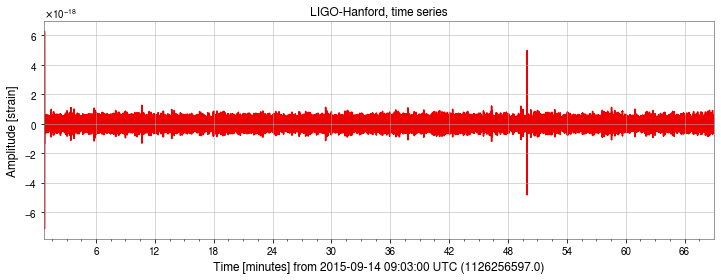

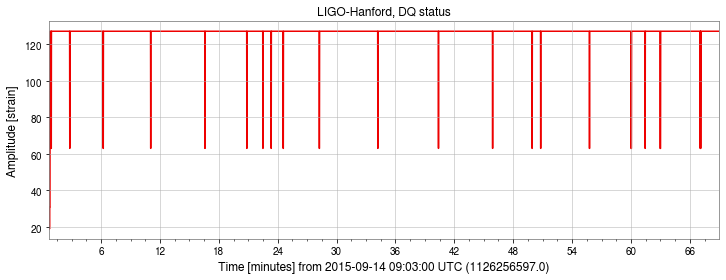

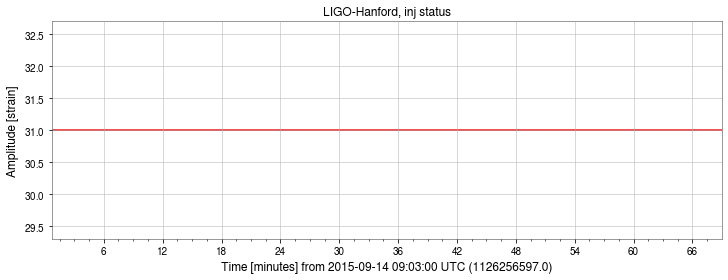

In [10]:
plot_series(series)
plot_series(series_dq, title='DQ status')
plot_series(series_inj, title='inj status')

We can zoom in on the spike...

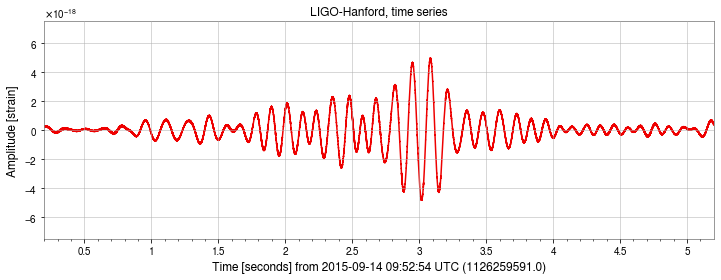

In [11]:
#first = 1126259462 + 0.2 # actual signal
first = 1126259591 + 0.2 # the glitch
last = first + 5
plot_series(series.crop(first, last), ylims=[-7.5e-18, 7.5e-18])

In fact, that is **not** the binary black hole (BBH) merger signal, a.ka., GW. Just another glitch...

# Frequency domain

Look at the amplitude spectral density (ASD), a.k.a., the frequency spectrum

In [12]:
def plot_asd(series, w=(4,2), xlims=None, ylims=None):
    asd = series.asd(*w)
    # => delta_f = 1/4 = 0.25 Hz
    plot = asd.plot(title='LIGO-Hanford, amplitude spectral density (ASD)', ylabel=r'ASD [$\sqrt{Hz}$]', color='gwpy:ligo-hanford')
    #print(plot.axes[0])
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.show()

def plot_psd(series, w=(4,2), xlims=None, ylims=None):
    # see: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.psd
    psd = series.psd(*w) # = (total_time_duration=sgdelta_t, stride_overlap=2 (default calculated internally as appropriate for window fn))
    # => delta_f = 1/4 = 0.25 Hz
    plot = psd.plot(title='LIGO-Hanford, power spectral density (PSD)', ylabel=r'PSD [Hz]', color='gwpy:ligo-hanford')
    #plot.axes[1].set_ylim(1e-20, 1e-15)
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.show()
    return psd

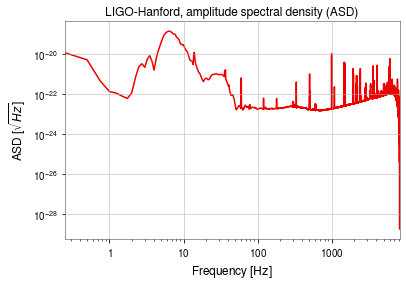

In [13]:
plot_asd(series, w=(4,2))

However, O1 data is not calibrated below 10 Hz or above 5 kHz (2 kHz for data at 4 kHz), so apply low pass and high pass filter, a.k.a., bandpass filter:  
Ref: https://www.gw-openscience.org/O1/

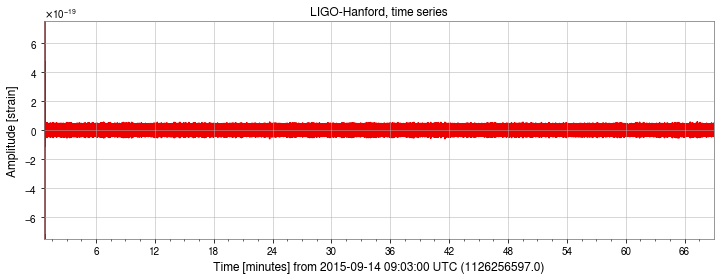

In [14]:
fcalib_lo, fcalib_hi = 16., 2048. # Hz
series_bp = series.bandpass(fcalib_lo, fcalib_hi) # or .highpass(fcalib_lo).lowpass(fcalib_hi)
plot_series(series_bp, ylims=[-7.5e-19, 7.5e-19])

Look at frequency domain again

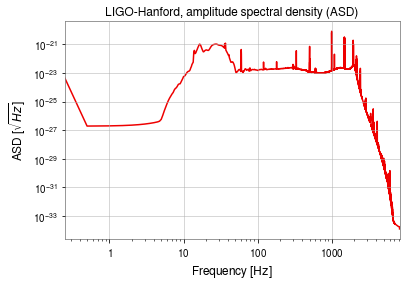

In [15]:
plot_asd(series_bp, w=(4,2))

Zoom in on bandpassed range

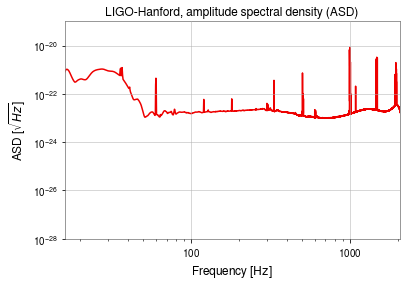

In [16]:
plot_asd(series_bp, w=(4,2), xlims=[fcalib_lo, fcalib_hi], ylims=[1.e-28, 1.e-19])

# Whiten data
Normalize to power density spectrum

In [17]:
def _fft_length_default(dt):
    # from https://github.com/gwpy/gwpy/blob/26f63684db17104c5d552c30cdf01248b2ec76c9/gwpy/timeseries/timeseries.py#L44
    """Choose an appropriate FFT length (in seconds) based on a sample rate
    Parameters
    ----------
    dt : `~astropy.units.Quantity`
        the sampling time interval, in seconds
    Returns
    -------
    fftlength : `int`
        a choice of FFT length, in seconds
    """
    return int(max(2, np.ceil(2048 * dt)))

def whiten_series(series, w=(4,2)):
    # pycbc
    # pycbc does truncation by default
    # comparing: https://github.com/gwpy/gwpy/blob/v2.0.4/gwpy/timeseries/timeseries.py#L1669
    # and https://pycbc.org/pycbc/latest/html/gw150914.html?highlight=whiten + https://pycbc.org/pycbc/latest/html/_modules/pycbc/types/timeseries.html#TimeSeries.whiten
    #series_pycbc = series.to_pycbc()
    #wht = series_pycbc.whiten(series.duration.value, _fft_length_default(series.dt.value))
    #wht = TimeSeries.from_pycbc(wht)
    # gwpy
    wht = series.whiten(*w)
    # truncate corrupted ends
    # from: https://pycbc.org/pycbc/latest/html/_modules/pycbc/types/timeseries.html#TimeSeries.whiten
    max_filter_duration = _fft_length_default(series.dt.decompose().value)
    max_filter_len = int(max_filter_duration * series.sample_rate.decompose().value)
    wht = wht[int(max_filter_len/2):-int(max_filter_len/2)]
    return wht

67076096


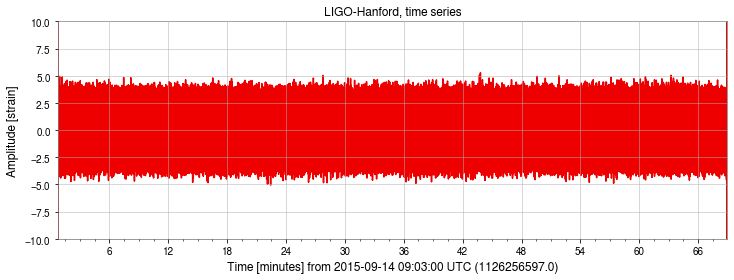

In [18]:
# To see GW signal in time series, need both whitening and BP
# Apply whiteningin to initial high pass calib, then apply more aggressive BP after
wht = whiten_series(series_bp)
plot_series(wht, ylims=[-10., 10.])
print(len(wht))

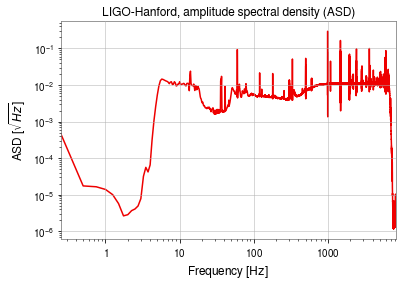

In [19]:
plot_asd(wht, w=(4,2))#, xlims=[fcalib_lo, fcalib_hi])#, ylims=[1.e-28, 1.e-19])

Apply basic analysis-level bandpass  
Different refs use different ranges, but in general, should be optimized to frequency spectrum of signal  
Refs: https://www.gw-openscience.org/tutorial_bandpass/, https://pycbc.org/pycbc/latest/html/gw150914.html, https://gwpy.github.io/docs/stable/examples/signal/gw150914.html

In [20]:
# Need to apply aggressive bandpass to limit noise from upper and lower freqs,
# in addition to whitening, to see GW signal in time domain
fsg_lo, fsg_hi = 35., 250. # Hz
'''
# Uncomment to apply basic bandpass filter only
wht = wht.bandpass(fsg_lo, fsg_hi) # or .highpass(fsg_lo).lowpass(fsg_hi)
plot_series(wht, ylims=[-0.75, 0.75])
'''

'\n# Uncomment to apply basic bandpass filter only\nwht = wht.bandpass(fsg_lo, fsg_hi) # or .highpass(fsg_lo).lowpass(fsg_hi)\nplot_series(wht, ylims=[-0.75, 0.75])\n'

Alternatively, chain (1) bandpass and (2) notch removal at harmonics of AC power supply (60 Hz, 120 Hz, 180 Hz, ...), into a single ZPK filter    
Ref: https://gwpy.github.io/docs/stable/examples/signal/gw150914.html, https://pycbc.org/pycbc/latest/html/gw150914.html

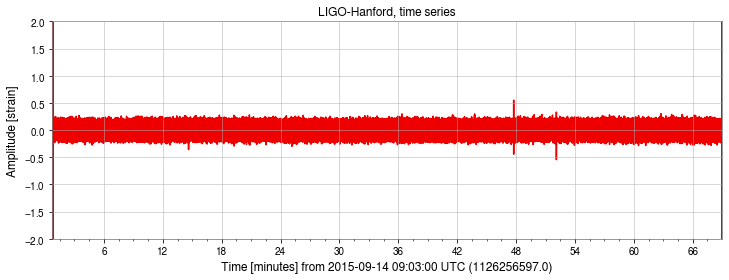

In [21]:
#'''
# define bandpass
bp = filter_design.bandpass(fsg_lo, fsg_hi, series.sample_rate)
# define notches
notches = [filter_design.notch(line, series.sample_rate) for line in (60, 120, 180)]
# chain filters
zpk = filter_design.concatenate_zpks(bp, *notches)
# set filtfilt=True to filter both backwards and forwards to preserve the correct phase at all frequencies
# see also: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.filter
wht = wht.filter(zpk, filtfilt=True)
#'''
plot_series(wht, ylims=[-2., 2.])

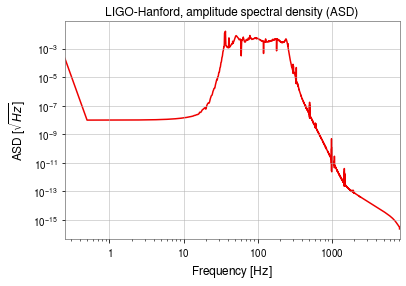

In [22]:
plot_asd(wht, w=(4,2))

Poles from the AC harmonics now cleaned

Zooming in on the spike in the time series...

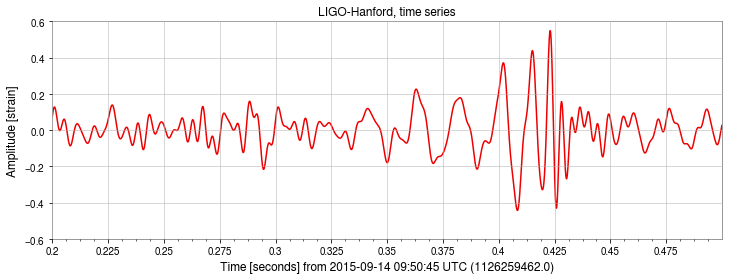

In [23]:
# When inspecting time domain only, can use tight windows
#sgfirst = 1126259591 + 0.2 # the first glitch
sgfirst = 1126259462 + 0.2 # this signal
#sfirst = 1126258757 + 16*60 + 6 + 0.3 # another glitch
sgdelta_t = 0.3
sglast = sgfirst + sgdelta_t

# Use whitened strain for time series
sg = wht.crop(sgfirst, sglast)
plot_series(sg, ylims=[-0.6, 0.6])

Which, indeed, is the merger signal GW

The same segment in the pre-whitened (but with the calib high pass) time series looks very different

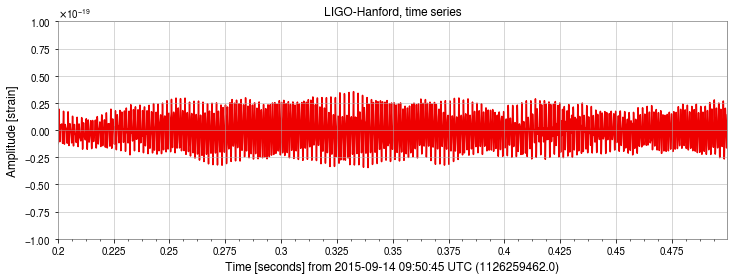

In [24]:
plot_series(series_bp.crop(sgfirst, sglast), ylims=[-1.e-19, 1.e-19])

# Making spectrograms

In [25]:
def plot_qt(qt, xlims=None, ylims=None):
    plot = qt.plot(title='LIGO-Hanford, Q-transform spectrogram', yscale='log')
    #print(plot.axes[0])
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.colorbar(cmap='viridis', label='Normalized energy')
    plot.show()

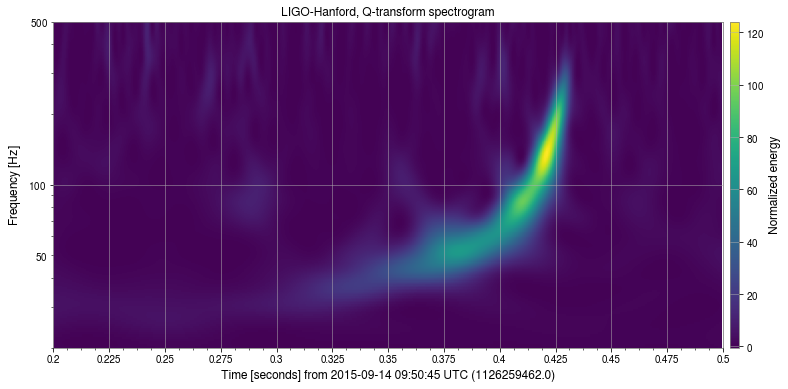

In [26]:
# Save computation/memory by only calculating **output** spectrogram on time segment of interest
# WARNING: Need to use sufficiently large time window around **input** waveform 
# in order to get good freq resolution in Fourier decomposition: about sg +/- 16 s

# peak position of different rois
#sgfirst = 1126259591 + 0.2 # the first glitch
#sgfirst = 1126259462 + 0.2 # this signal
#sfirst = 1126258757 + 16*60 + 6 + 0.3 # another glitch

# For spectrograms, need to choose sufficiently long time duration ~ 32 s
# to ensure good resolution and range in freq domain / Fourier space
sgfirst = 1126259446
sgdelta_t = 32
sglast = sgfirst + sgdelta_t

#qfirst = 1126259591 + 0.2 # the first glitch
qfirst = 1126259462 + 0.2 # this signal
#qfirst = 1126258757 + 16*60 + 6 + 0.3 # another glitch
qlast = qfirst + 0.3

# NOTE: whitening is only really for cleaning time series
# spectrograms are cleaner without whitening
# but can still benefit from bandpass
qt = series.crop(sgfirst, sglast).q_transform(outseg=(qfirst, qlast))
plot_qt(qt, ylims=[20., 500.])

# Calculate signal-to-noise ratio
Determine significance of ROI wrt some sg template + noise

First, generate a signal template overlaid onto the same background PSD  
Ref: https://gwpy.github.io/docs/stable/examples/timeseries/pycbc-snr.html, https://pycbc.org/pycbc/latest/html/gw150914.html#listen-to-gw150914-in-hanford, https://www.gw-openscience.org/tutorial_optimal/

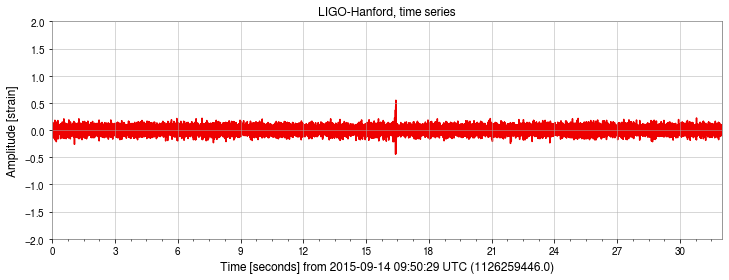

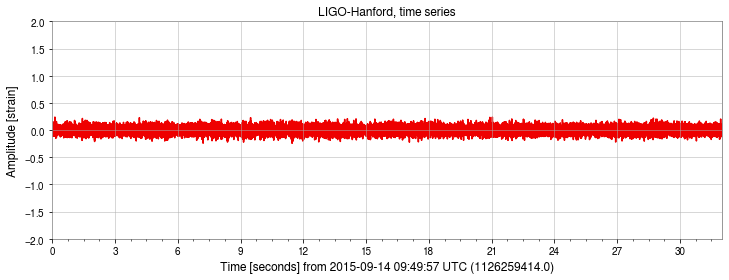

In [27]:
# Apply matched filtering first
# In practice, the matched filtering is used to localize ROIs
# rather than the other way around, as we are doing here.
# However, it is extremely computationally expensive to find ROIs
# with matched filtering because of template window, GW physics params,
# and data striding

# peak position of different rois
#sgfirst = 1126259591 + 0.2 # the first glitch
#sgfirst = 1126259462 + 0.2 # this signal
#sfirst = 1126258757 + 16*60 + 6 + 0.3 # another glitch
#sglast = sgfirst + 0.3

# For PSD in matched filtering, need to choose sufficiently long time duration
# to ensure good resolution in freq domain / Fourier space where normalization is done
# see: https://www.gw-openscience.org/tutorial_optimal/
# but not too long either, otherwise PSD gets diluted, choose delta_t ~ 32 s
sgfirst = 1126259446
sgdelta_t = 32
sglast = sgfirst + sgdelta_t

# Do not apply whitening either as matched filtering will normalize to PSD
# NOTE: must use band pass with upper limit > simulated signal GW template upper bound ~ 560 Hz
# so use pre-bp series and apply a higher upper bound
fsg_lo, fsg_hi = 35., 600. # Hz

# Not sensitive to whether BP applied before or after PSD window selection
# Sg series: contains actual GW signal
#sg = series.crop(sgfirst, sglast).bandpass(fsg_lo, fsg_hi)
sg = series.bandpass(fsg_lo, fsg_hi).crop(sgfirst, sglast) # seems to work as well
# Bg series: needed to calculate a bkg PSD to normalize sg in matched-filtered SNR
# In practice, not necessary to select seprate time window from sg to calculate PSD but
# probably more correct to do so, per Ref above
#bg = series.crop(sgfirst-sgdelta_t, sgfirst).bandpass(fsg_lo, fsg_hi)
bg = series.bandpass(fsg_lo, fsg_hi).crop(sgfirst-sgdelta_t, sgfirst) # seems to work as well

# plot whitened time series to verify sg contains GW and bg contains no glitches (probably not essential)
# Check to make sure there are no glitches here
# NOTE: this is only for visual verification, for actual matched filtering
# do NOT use whitened series as this will destroy PSD normalization!
plot_series(wht.crop(sgfirst, sglast), ylims=[-2., 2.])
plot_series(wht.crop(sgfirst-sgdelta_t, sgfirst), ylims=[-2., 2.])

In [28]:
# Get background PSD for matched filter normalization
# IMPT! The matched filtering has its own optimal template window, separate from that needed
# for the PSD. The optimal GW template window per tutorials is ~ 4s,
# which resumably has to do with the duration of the GW signal itself
# If you pick the wrong GW time window, the SNR peak will NOT show!
# Conclusion: matched filtering extremely delicate!
sgfirst = 1126259460
sgdelta_t = 4
sglast = sgfirst + sgdelta_t

# Restrict to GW time window
sg = sg.crop(sgfirst, sglast)

# Consequently, the FFT window in PSD conversion needs to be chosen such that
# the PSD freq resolution/step size corresponds to the GW time window,
# i.e. FFT window = GW time window = 4 s => delta_f = 1 / 4 s = 0.25 Hz
psd = bg.psd(4, 2) # = (fft window=4, stride_overlap=2 (default calculated internally as appropriate for window fn))
# see: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.psd
print(len(psd))

# Calculate freq domain of simulated GW template
# `f_final` determines the final freq in the pycbc.FrequencySeries but not the final **simulated** freq
# which is instead determined internally by the simulation to be ~560 Hz.
# By contrast, `f_lower` determines the lowest freq that will be simulated, but the series always begins at f = 0 Hz.
# If `f_final` is not specified, then it will default to ~1 kHz, which will need to be padded
# to match the default final freq of a pycbc.FrequencySeries = 8.192 kHz
# the padding is done by calling .resize() which will simply zero-pad the additional higher freqs
# this can be avoided by explicitly specifying `f_final`.
hp, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32, #f_lower=fcalib_lo, delta_f=psd.df.value)
                         f_lower=fcalib_lo, f_final=psd.xindex[-1].value, delta_f=psd.df.value)

# These need to be identical for the matched filtering to work
print(psd.df) # gwpy
print(hp.delta_f) # pycbc

32769
0.25 Hz
0.25


In [29]:
print(psd.xindex)
print(psd.xspan)
print(len(psd))

[0.00000e+00 2.50000e-01 5.00000e-01 ... 8.19150e+03 8.19175e+03
 8.19200e+03] Hz
[0.0 ... 8192.25)
32769


In [30]:
# In addtion per the FFT, len(hp) must equal the len(FFT(sg)) = len(sg)//2 + 1
print(len(bg), len(psd), len(hp), len(sg), len(sg.psd()), len(sg)//2 +1)

524288 32769 32769 65536 32769 32769


0.0 0.25 8192.0
32769
16.0 2048.0
[15.   15.25 15.5  15.75 16.   16.25 16.5  16.75 17.   17.25]
[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  4.97773961e-20-0.00000000e+00j -1.05389180e-20+4.76758864e-20j
 -4.48635751e-20-1.68043975e-20j  1.94645455e-20-4.27997324e-20j
  4.20149120e-20+1.91099912e-20j -1.60623676e-20+4.23809005e-20j]
[562.5  562.75 563.   563.25 563.5  563.75 564.   564.25 564.5
 564.75]
[-1.00632152e-25-6.46133737e-27j -1.00005566e-25-6.42203778e-27j
 -9.93830259e-26-6.38287724e-27j -9.87645055e-26-6.34385622e-27j
 -9.81499773e-26-6.30497518e-27j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]


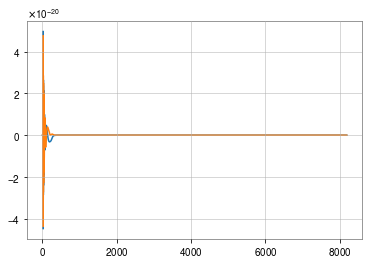

In [31]:
hp_freqs = hp.get_sample_frequencies()
print(hp_freqs[0], hp_freqs[1], hp_freqs[-1])
print(len(hp_freqs))
print(fcalib_lo, fcalib_hi)
# check low end
print(hp_freqs[60:70])
print(hp.data[60:70])
# check high end
print(hp_freqs[2250:2260])
print(hp.data[2250:2260])
plot = hp.plot()

0.0 0.25 8192.0
32769
[15.   15.25 15.5  15.75 16.   16.25 16.5  16.75 17.   17.25]
[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  4.97773961e-20-0.00000000e+00j -1.05389180e-20+4.76758864e-20j
 -4.48635751e-20-1.68043975e-20j  1.94645455e-20-4.27997324e-20j
  4.20149120e-20+1.91099912e-20j -1.60623676e-20+4.23809005e-20j]
[562.5  562.75 563.   563.25 563.5  563.75 564.   564.25 564.5
 564.75]
[-1.00632152e-25-6.46133737e-27j -1.00005566e-25-6.42203778e-27j
 -9.93830259e-26-6.38287724e-27j -9.87645055e-26-6.34385622e-27j
 -9.81499773e-26-6.30497518e-27j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]


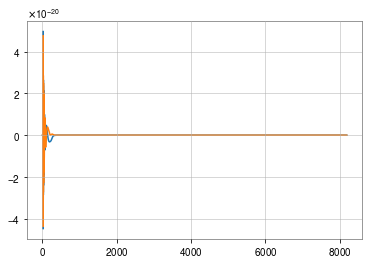

In [32]:
# dont need to resize if you specify `f_final` to match that of i.e gwpy default
#'''
hp.resize(len(sg)//2 + 1)
hp_freqs = hp.get_sample_frequencies()
print(hp_freqs[0], hp_freqs[1], hp_freqs[-1])
print(len(hp_freqs))
# check low end
print(hp_freqs[60:70])
print(hp.data[60:70])
# check high end
print(hp_freqs[2250:2260])
print(hp.data[2250:2260])
plot = hp.plot()
#'''

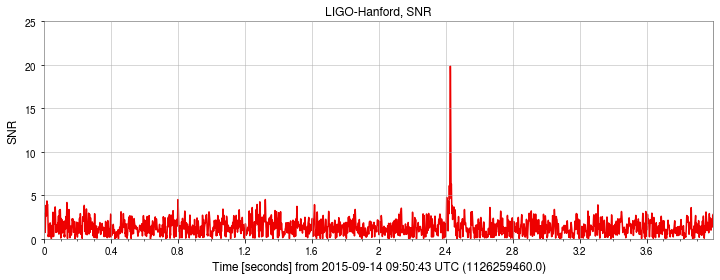

In [33]:
snr = matched_filter(hp, sg.to_pycbc(), psd=psd.to_pycbc(), low_frequency_cutoff=fsg_lo)
snrts = TimeSeries.from_pycbc(snr).abs()
plot_series(snrts, title='SNR', ylabel='SNR', ylims=[0., 25.])#, xlims=[1126259462.2, 1126259462.2+4])